# Retrieve and Analyze Snotel data for a watershed of interest
Authors: Irene Garousi-Nejad (igarousi@cuahsi.org), Ryan Johnson (ryan.c.johnson@utah.edu)
Last updated: January 9th, 2025

This notebook support the CIROH HydroLearn module Introduction to Seasonal Snow Observations, Modeling, and Analysis, demonstrating how to access NRCS SNOTEL data, in particular, snow depth and snow-water-equivalent. 

Supplementary Code:

To simplify this notebook, we developed several helper functions that can be imported from the supporting_scripts folder. 


# 1. Create Map for Watershed for USGS Station ID
The following code uses the pynhd and folium packages to create an interactive map of a watershed from a USGS gauge ID.

In our exercise, we are tasked with identifying all SNOTEL sites upstream of Hetch Hetchy Reservoir on the Tuolumne River. The user can search for "USGS streamflow Tuolumne River" and serveral locations will pop up. Site [11274790](https://waterdata.usgs.gov/monitoring-location/11274790/#dataTypeId=continuous-00065-0&period=P7D&showMedian=false) is the site of interest for this assessment 

In [11]:
from pynhd import NLDI, WaterData, NHDPlusHR, GeoConnex
import geopandas as gpd
import pandas as pd
from supporting_scripts import getData, SNOTEL_Analyzer, dataprocessing, folium_mapping
from shapely.geometry import box, Polygon
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
 

Define the watershed outlet using NWIS site id. Create a map object that we'll add layers to.

In [2]:
nldi = NLDI()
usgs_gage_id = "11274790" # NWIS id for Tuolumne river at the mouth of Hetch Hetchy Reservoir

Collect watershed and reach vectors using the pynhd module.

In [3]:
nldi = NLDI()

#Getting basin geometry
print('Collecting basins...', end='')
basin = nldi.get_basins(usgs_gage_id)
if not os.path.exists('files'):
    os.makedirs('files')
basin.to_file("files/TuolumneRiverBasin.shp")
print('done')

site_feature = nldi.getfeature_byid("nwissite", f"USGS-{usgs_gage_id}")
upstream_network = nldi.navigate_byid(
    "nwissite", f"USGS-{usgs_gage_id}", "upstreamMain", "flowlines", distance=9999
)

Create and interactive map to display the watershed.

In [4]:
# create map
folium_mapping.basin_mapping(basin, site_feature)

# 1. Identify SNOTEL sites within a spatial domain

In [5]:
# Create geodataframe of all stations
all_stations_gdf = gpd.read_file('https://raw.githubusercontent.com/egagli/snotel_ccss_stations/main/all_stations.geojson').set_index('code')
all_stations_gdf = all_stations_gdf[all_stations_gdf['csvData']==True]

# Use the polygon geometry to select snotel sites that are within the domain
gdf_in_bbox = all_stations_gdf[all_stations_gdf.geometry.within(basin.geometry[0])]

#reset index to have siteid as a column
gdf_in_bbox.reset_index(drop=False, inplace=True)

#make begin and end date a str
gdf_in_bbox['beginDate'] = [datetime.datetime.strftime(gdf_in_bbox['beginDate'][i], "%Y-%m-%d") for i in np.arange(0,len(gdf_in_bbox),1)]
gdf_in_bbox['endDate'] = [datetime.datetime.strftime(gdf_in_bbox['endDate'][i], "%Y-%m-%d") for i in np.arange(0,len(gdf_in_bbox),1)]
gdf_in_bbox

/home/whitelightning450/mambaforge/envs/HydroLearnEnv/lib/python3.10/site-packages/geopandas/geoseries.py:720: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*args, **kwargs)


,code,name,network,elevation_m,latitude,longitude,state,HUC,mgrs,mountainRange,beginDate,endDate,csvData,geometry
0,TUM,Tuolumne Meadows,CCSS,2621.280,37.876406,-119.348096,California,180400090102,11SKB,Sierra Nevada,2004-10-01,2025-01-09,True,POINT (-119.3481 37.87641)
1,TES,Tioga Pass Entry Station,CCSS,3031.236,37.910870,-119.258507,California,180400090102,11SLB,Sierra Nevada,2004-10-01,2025-01-08,True,POINT (-119.25851 37.91087)
2,DAN,Dana Meadows,CCSS,2987.040,37.896162,-119.257260,California,180400090102,11SLB,Sierra Nevada,2004-10-01,2025-01-09,True,POINT (-119.25726 37.89616)
3,SLI,Slide Canyon,CCSS,2804.160,38.091234,-119.431881,California,180400090501,11SKC,Sierra Nevada,2005-10-01,2025-01-09,True,POINT (-119.43188 38.09123)


Add the SNOTEL monitoring station locations to the map

In [6]:
folium_mapping.snotel_mapping(gdf_in_bbox, basin, site_feature)

# 2. Retrieve data for the selected sites

The following uses the getData.py script to download SNOTEL data for the sites within the domain. Inputs to this script include the SNOTEL site name, site ID, and state abbreviation, which are retrieved from the geodataframe above. Additional inputs include the start and end dates, as well as the path to save the outputs.

In [7]:
# Use the getData module to retrieve data 
OutputFolder = 'files/SNOTEL'
if not os.path.exists(OutputFolder):
    os.makedirs(OutputFolder)

for i in gdf_in_bbox.index:
    print(i)
    getData.getCaliSNOTELData(gdf_in_bbox.name[i], gdf_in_bbox.code[i], gdf_in_bbox.beginDate[i], gdf_in_bbox.endDate[i], OutputFolder)

0
Start retrieving data for Tuolumne Meadows, TUM
https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customMultiTimeSeriesGroupByStationReport/daily/start_of_period/TUM:CA:MSNT%257Cid=%2522%2522%257Cname/2004-10-01,2025-01-09/WTEQ::value?fitToScreen=false
1
Start retrieving data for Tioga Pass Entry Station, TES
https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customMultiTimeSeriesGroupByStationReport/daily/start_of_period/TES:CA:MSNT%257Cid=%2522%2522%257Cname/2004-10-01,2025-01-08/WTEQ::value?fitToScreen=false
2
Start retrieving data for Dana Meadows, DAN
https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customMultiTimeSeriesGroupByStationReport/daily/start_of_period/DAN:CA:MSNT%257Cid=%2522%2522%257Cname/2004-10-01,2025-01-09/WTEQ::value?fitToScreen=false
3
Start retrieving data for Slide Canyon, SLI
https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customMultiTimeSeriesGroupByStationReport/daily/start_of_period/SLI:CA:MSNT%257Cid=%2522%2522%257Cname/2005-10-01,2025-

# 3.  Process the data to enable plotting and analysis

In [8]:
# Load the data for one site
sites = list(gdf_in_bbox.code)
stateab = 'Ca'
sitedict = dict()

for site in sites:
    sitedict[site] = dataprocessing.processSNOTEL(site, stateab)

sitedict['TUM']

TUM












TES
DAN











SLI













,M,D,2005_SWE_in,2006_SWE_in,2007_SWE_in,2008_SWE_in,2009_SWE_in,2010_SWE_in,2011_SWE_in,2012_SWE_in,...,2022_SWE_in,min,Q10,Q25,mean,median,Q75,Q90,max,date
M-D,,,,,,,,,,,,,,,,,,,,,
10-01,10,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-01
10-02,10,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-02
10-03,10,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-03
10-04,10,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-04
10-05,10,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
07-27,7,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-07-27
07-28,7,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-07-28
07-29,7,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-07-29


# 4. Make a snow report for WY2019

In [56]:
import importlib
importlib.reload(SNOTEL_Analyzer)

<module 'supporting_scripts.SNOTEL_Analyzer' from '/home/whitelightning450/Intro-to-Snow-Observations-Modeling-Analysis/supporting_scripts/SNOTEL_Analyzer.py'>

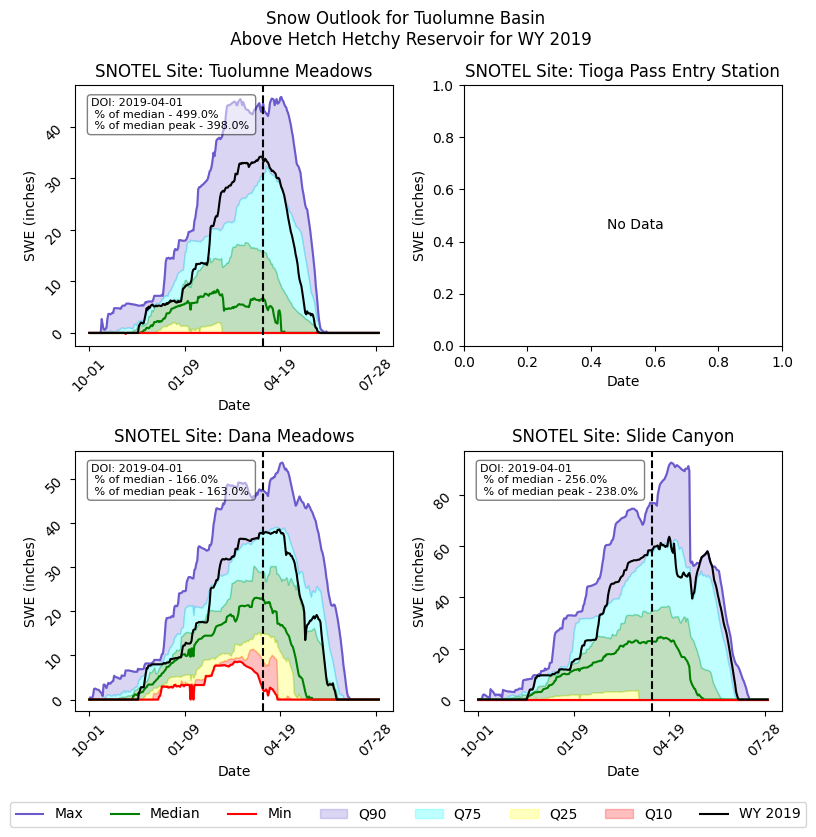

In [59]:
WY = 2019
watershed = "Tuolumne"
AOI = 'Above Hetch Hetchy Reservoir'
DOI = '04-01' #must be in MM-DD form
SNOTEL_Analyzer.SNOTELPlots(sitedict, gdf_in_bbox, WY, watershed, AOI,DOI)

In [32]:
max(sitedict['DAN']['median'])

23.11551248237

In [51]:
df =  sitedict['DAN']

round(df[f"{WY}_SWE_in"][df.index == DOI]/10 *100, 0)

/tmp/ipykernel_12886/3272310165.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  round(df[f"{WY}_SWE_in"][df.index == DOI][0]/10 *100, 0)


np.float64(181.0)

In [50]:
df[f"{WY}_SWE_in"][df.index == DOI][0]

/tmp/ipykernel_12886/1117402247.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df[f"{WY}_SWE_in"][df.index == DOI][0]


np.float64(18.100009774)